Create a sample Sqlite datasets for Books and write ipynb codes for ETL, Data Visualizations and Machine Learning to predict best selller

In [219]:
# Import required libraries
import sqlite3
import random
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [221]:
import warnings
warnings.filterwarnings('ignore')

Create a sample SQLite dataset that matches the ETL and visualization code. Make a simple script to create the database and populate it with some sample data. 

In [189]:
# Connect to the SQLite database (this will create the file if it doesn't exist)
conn = sqlite3.connect('book_sales.db')
cursor = conn.cursor()

# Create the books table
cursor.execute('''
CREATE TABLE IF NOT EXISTS books (
    book_id INTEGER PRIMARY KEY,
    title TEXT NOT NULL,
    author TEXT NOT NULL,
    genre TEXT NOT NULL
)
''')

# Create the sales table
cursor.execute('''
CREATE TABLE IF NOT EXISTS sales (
    sale_id INTEGER PRIMARY KEY,
    book_id INTEGER,
    sale_date DATE NOT NULL,
    quantity INTEGER NOT NULL,
    price REAL NOT NULL,
    FOREIGN KEY (book_id) REFERENCES books (book_id)
)
''')

# Sample data
books = [
    ("To Kill a Mockingbird", "Harper Lee", "Fiction"),
    ("1984", "George Orwell", "Science Fiction"),
    ("Pride and Prejudice", "Jane Austen", "Romance"),
    ("The Great Gatsby", "F. Scott Fitzgerald", "Fiction"),
    ("The Hobbit", "J.R.R. Tolkien", "Fantasy"),
    ("Sapiens", "Yuval Noah Harari", "Non-fiction"),
    ("The Da Vinci Code", "Dan Brown", "Thriller"),
    ("The Hunger Games", "Suzanne Collins", "Young Adult"),
    ("The Catcher in the Rye", "J.D. Salinger", "Fiction"),
    ("Harry Potter and the Philosopher's Stone", "J.K. Rowling", "Fantasy")
]

# Insert books
cursor.executemany("INSERT INTO books (title, author, genre) VALUES (?, ?, ?)", books)

# Generate sample sales data
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
dates = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

sales_data = []
for _ in range(1000):  # Generate 1000 sales records
    book_id = random.randint(1, len(books))
    sale_date = random.choice(dates).strftime("%Y-%m-%d")
    quantity = random.randint(1, 5)
    price = round(random.uniform(9.99, 29.99), 2)
    sales_data.append((book_id, sale_date, quantity, price))

# Insert sales data
cursor.executemany("INSERT INTO sales (book_id, sale_date, quantity, price) VALUES (?, ?, ?, ?)", sales_data)

# Commit changes and close connection
conn.commit()
conn.close()

print("Sample book sales database created successfully.")

Sample book sales database created successfully.


IPython Notebook (ipynb) code that demonstrates ETL (Extract, Transform, Load) from the created sample SQLite dataset and includes data visualizations. Using a hypothetical database of book sales for this example.

In [192]:
# Connect to the SQLite database
conn = sqlite3.connect('book_sales.db')

# Extract: Query the database and load data into a pandas DataFrame
query = """
SELECT 
    b.title,
    b.author,
    b.genre,
    s.sale_date,
    s.quantity,
    s.price
FROM 
    books b
JOIN 
    sales s ON b.book_id = s.book_id
"""
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Transform: Process and clean the data
df['sale_date'] = pd.to_datetime(df['sale_date'])
df['total_sale'] = df['quantity'] * df['price']
df['month'] = df['sale_date'].dt.to_period('M')

# Group sales by month and genre
monthly_genre_sales = df.groupby(['month', 'genre'])['total_sale'].sum().unstack()

<Figure size 1200x600 with 0 Axes>

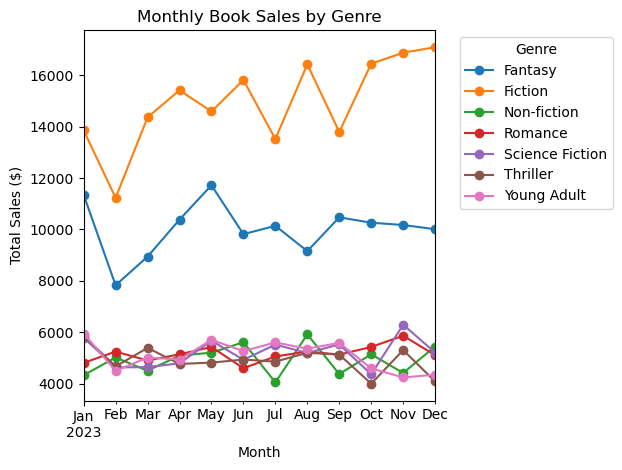

In [194]:
# Visualization 1: Line plot of monthly sales by genre
plt.figure(figsize=(12, 6))
monthly_genre_sales.plot(kind='line', marker='o')
plt.title('Monthly Book Sales by Genre')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

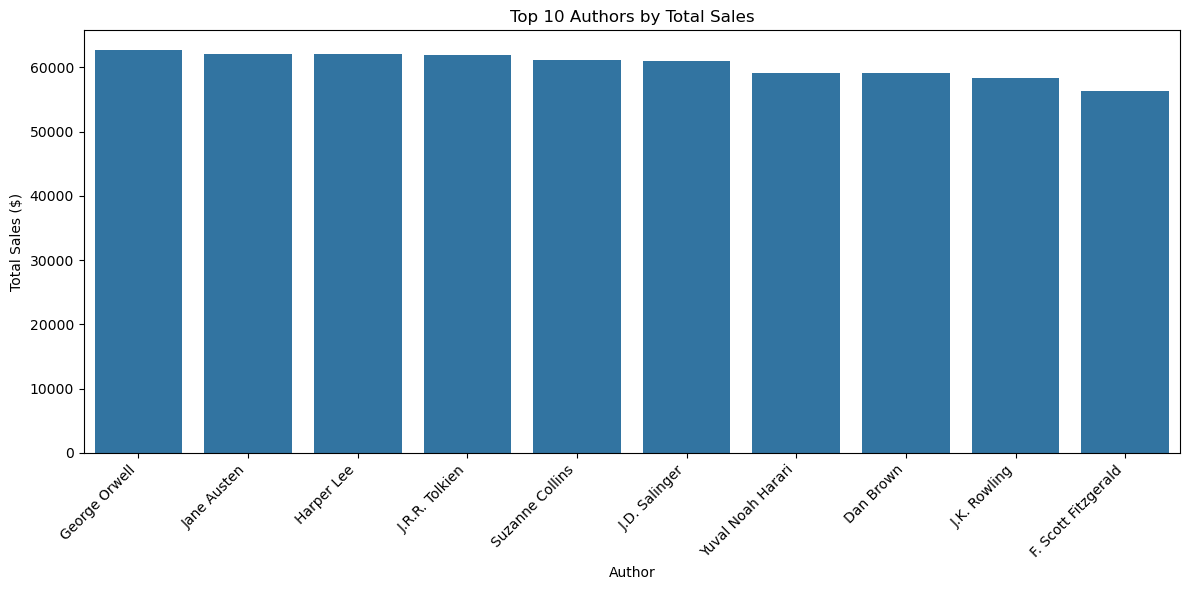

In [196]:
# Visualization 2: Bar plot of total sales by author (top 10)
top_authors = df.groupby('author')['total_sale'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_authors.index, y=top_authors.values)
plt.title('Top 10 Authors by Total Sales')
plt.xlabel('Author')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

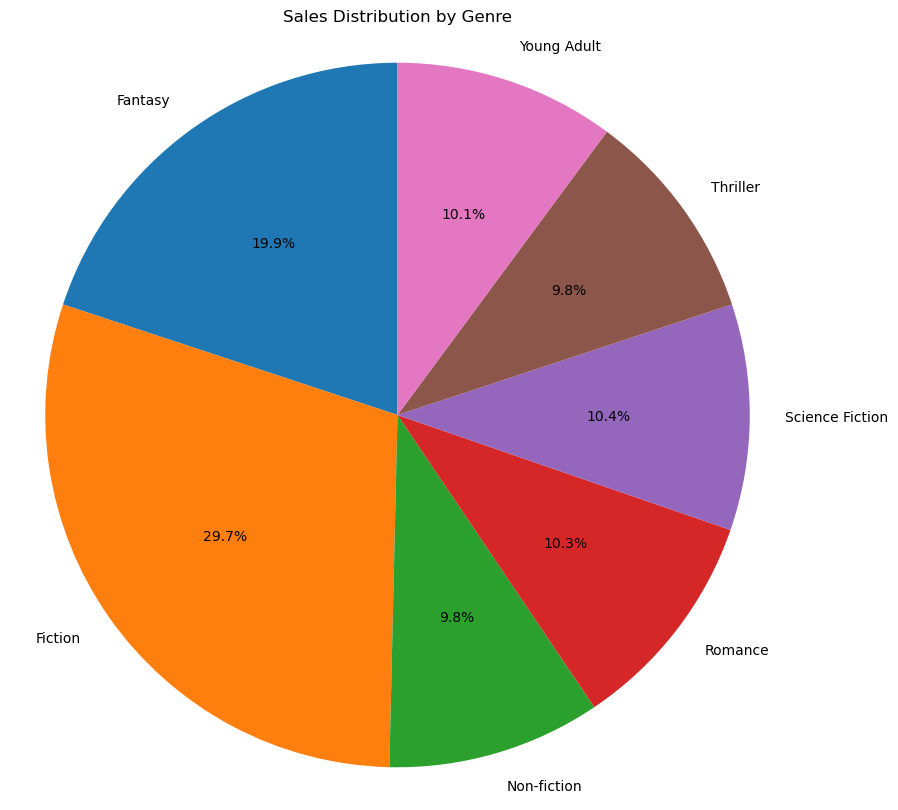

In [198]:
# Visualization 3: Pie chart of sales distribution by genre
genre_sales = df.groupby('genre')['total_sale'].sum()
plt.figure(figsize=(10, 10))
plt.pie(genre_sales, labels=genre_sales.index, autopct='%1.1f%%', startangle=90)
plt.title('Sales Distribution by Genre')
plt.axis('equal')
plt.show()

In [200]:
# Load: Save the processed data to a CSV file
df.to_csv('processed_book_sales.csv', index=False)
print("Processed data saved to 'processed_book_sales.csv'")

Processed data saved to 'processed_book_sales.csv'


In [202]:
# Connect to the SQLite database
conn = sqlite3.connect('book_sales.db')

# Extract data
query = """
SELECT 
    b.book_id,
    b.title,
    b.author,
    b.genre,
    SUM(s.quantity) as total_quantity,
    SUM(s.quantity * s.price) as total_revenue
FROM 
    books b
JOIN 
    sales s ON b.book_id = s.book_id
GROUP BY 
    b.book_id
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Define bestseller threshold (top 20% by total revenue)
bestseller_threshold = df['total_revenue'].quantile(0.8)
df['is_bestseller'] = (df['total_revenue'] >= bestseller_threshold).astype(int)

# Prepare features and target
X = df[['genre', 'total_quantity']]
y = df['is_bestseller']

# Encode categorical variables
le = LabelEncoder()
X['genre'] = le.fit_transform(X['genre'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [203]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



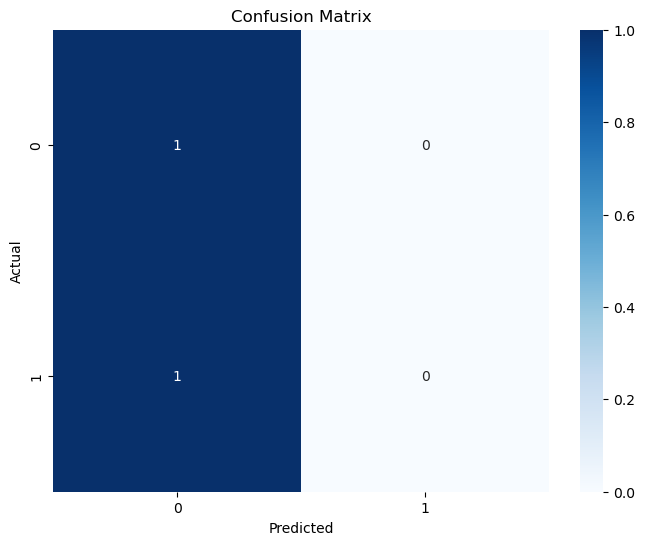

In [206]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

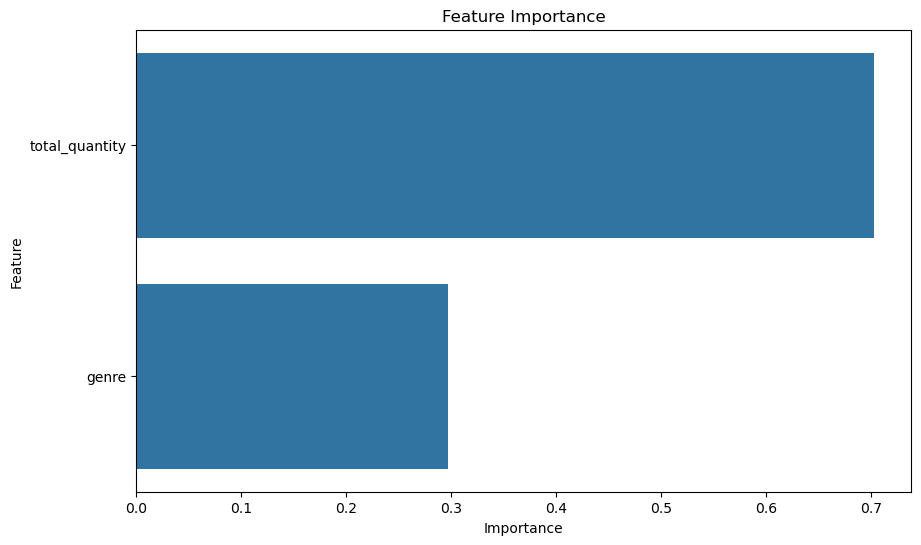

In [208]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [209]:
# Predict bestseller status for all books
df['predicted_bestseller'] = rf_model.predict(X)

In [212]:
# Display top predicted bestsellers
top_predicted_bestsellers = df[df['predicted_bestseller'] == 1].sort_values('total_revenue', ascending=False)
print("\nTop Predicted Bestsellers:")
print(top_predicted_bestsellers[['title', 'author', 'genre', 'total_revenue']].head())


Top Predicted Bestsellers:
                 title       author    genre  total_revenue
2  Pride and Prejudice  Jane Austen  Romance       62035.66


In [214]:
# Display actual bestsellers
actual_bestsellers = df[df['is_bestseller'] == 1].sort_values('total_revenue', ascending=False)
print("\nActual Bestsellers:")
print(actual_bestsellers[['title', 'author', 'genre', 'total_revenue']].head())


Actual Bestsellers:
                 title         author            genre  total_revenue
1                 1984  George Orwell  Science Fiction       62625.22
2  Pride and Prejudice    Jane Austen          Romance       62035.66
